<a href="https://colab.research.google.com/github/pingwx/ya.prac/blob/main/04_Statistical_data_analysis/04_RU_Statistical_data_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Определение перспективного тарифа для телеком-компании

В нашем распоряжении данные о звонках, интернет-трафике и сообщениях пользователей мобильного оператора "Мегалайн". Пользователям доступны два тарифа: "Смарт" и "Ультра". Предлагается выяснить, какой из них приносит больше денег компании, чтобы в последствие скорректировать рекламный бюджет. Данные представлены для 500 пользователей "Мегалайна" за 2018 год.

**Тариф "Смарт"**
1. Ежемесячная плата: 550 рублей
2. Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
3. Стоимость услуг сверх тарифного плана:
   - минута разговора: 3 рубля
   - сообщение: 3 рубля
   - 1 Гб интернет-трафика: 200 рублей
   
**Тариф "Ультра"**
1. Ежемесячная плата: 1950 рублей
2. Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
3. Стоимость услуг сверх тарифного плана:
   - минута разговора: 1 рубль
   - сообщение: 1 рубль
   - 1 Гб интернет-трафика: 150 рублей
   
**Примечание:**
«Мегалайн» всегда округляет секунды до минут, а мегабайты — до гигабайт. Каждый звонок округляется отдельно: даже если он длился всего 1 секунду, будет засчитан как 1 минута.
Для веб-трафика отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в бо́льшую сторону. Если абонент использует 1025 мегабайт в этом месяце, с него возьмут плату за 2 гигабайта.

**Описание данных**

Таблица `users` (информация о пользователях):
- `user_id` — уникальный идентификатор пользователя
- `first_name` — имя пользователя
- `last_name` — фамилия пользователя
- `age` — возраст пользователя (годы)
- `reg_date` — дата подключения тарифа (день, месяц, год)
- `churn_date` — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
- `city` — город проживания пользователя
- `tariff` — название тарифного плана

Таблица `calls` (информация о звонках):
- `id` — уникальный номер звонка
- `call_date` — дата звонка
- `duration` — длительность звонка в минутах
- `user_id` — идентификатор пользователя, сделавшего звонок

Таблица `messages` (информация о сообщениях):
- `id` — уникальный номер сообщения
- `message_date` — дата сообщения
- `user_id` — идентификатор пользователя, отправившего сообщение

Таблица `internet` (информация об интернет-сессиях):
- `id` — уникальный номер сессии
- `mb_used` — объём потраченного за сессию интернет-трафика (в мегабайтах)
- `session_date` — дата интернет-сессии
- `user_id` — идентификатор пользователя

Таблица `tariffs` (информация о тарифах):
- `tariff_name` — название тарифа
- `rub_monthly_fee` — ежемесячная абонентская плата в рублях
- `minutes_included` — количество минут разговора в месяц, включённых в абонентскую плату
- `messages_included` — количество сообщений в месяц, включённых в абонентскую плату
- `mb_per_month_included` — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
- `rub_per_minute` — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
- `rub_per_message` — стоимость отправки сообщения сверх тарифного пакета
- `rub_per_gb` — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

По итогам исследования проверим следующие **гипотезы**:

1. Средняя выручка пользователей тарифов "Ультра" и "Смарт" различаются
2. Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

## Изучение данных из файла

In [2]:
import pandas as pd
import numpy as np
from scipy import stats as st

Последовательно откроем датасеты и изучим общую информацию о них.

In [3]:
calls = pd.read_csv('/content/calls.csv')
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


In [4]:
calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


In [5]:
len(calls['user_id'].unique()) #Количество уникальных user_id в таблице calls

492

Обратим внимание на следующие вещи:
1. Столбец `call_date` имеет тип `object`, а нам удобнее было бы работать с `datetime`, поэтому будем его преобразовывать
2. Данные в столбце `duration` содержат дробную часть, а по условию задачи, звонки клиентов округляются до минут в большую сторону, поэтому это мы и сделаем в датасете
3. Восемь пользователей из пятисот не совершили ни одного звонка
4. Пропусков в датасете нет

Посмотрим, как распределены данные в самом важном для нас столбце - `duration`

In [6]:
calls['duration'].describe()

count    202607.000000
mean          6.755887
std           5.843365
min           0.000000
25%           1.300000
50%           6.000000
75%          10.700000
max          38.000000
Name: duration, dtype: float64

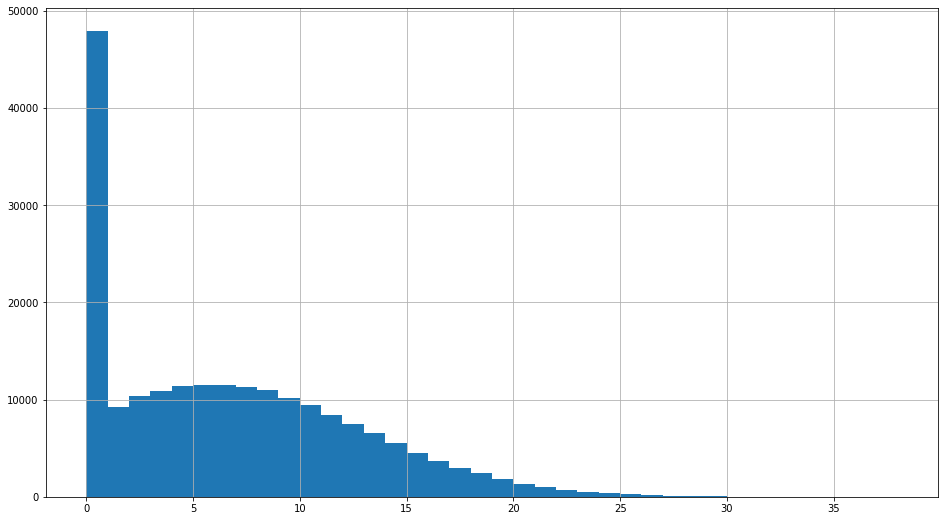

In [7]:
calls['duration'].hist(bins=38, figsize=(16, 9));

По условию задачи `duration = 0` означает пропущенный звонок и, ожидаемо, на нуле мы видим большой пик, распределение остальных звонков похоже на нормальное. Таким образом, проблем в данных этого столбца не наблюдается

Откроем следующий датасет `internet`

In [8]:
internet = pd.read_csv('/content/internet.csv')
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


In [9]:
internet.head()

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


In [10]:
len(internet['user_id'].unique()) #Количество уникальных user_id в таблице internet

497

Видим столбец `Unnamed: 0`, который повторяет индексы датасета,его удалим просто. В остальном картина аналогична датасету звонков. Снова нет записей нескольких пользователей. Снова тип данных `object` у столбца с датой. Единственная разница заключается в том, что значения мегабайтов округлять мы будем не сразу, как в случае со звонками, а  сначала просуммируем их, поделим на 1024 и округлим до большего. Снова не наблюдаем пропуски.

Глянем на распределение столбца `mb_used`

In [11]:
internet['mb_used'].describe()

count    149396.000000
mean        370.192426
std         278.300951
min           0.000000
25%         138.187500
50%         348.015000
75%         559.552500
max        1724.830000
Name: mb_used, dtype: float64

In [12]:
internet['mb_used'].value_counts()

0.00      19598
335.91        9
447.30        9
197.56        9
199.11        8
          ...  
643.43        1
973.04        1
834.51        1
777.30        1
23.72         1
Name: mb_used, Length: 70003, dtype: int64

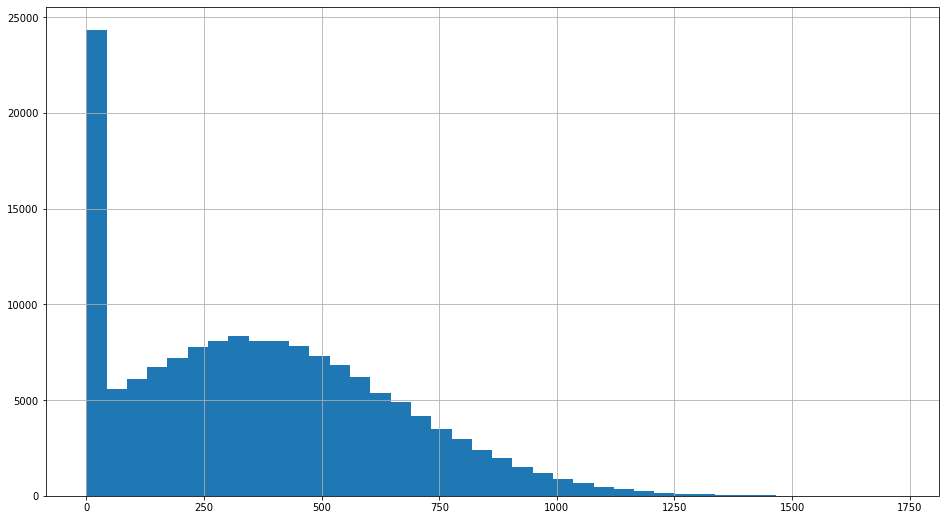

In [13]:
internet['mb_used'].hist(bins=40, figsize=(16, 9));

Снова видим колоколообразное распределение.

Откроем следующий датасет `messages`.

In [14]:
messages = pd.read_csv('/content/messages.csv')
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


In [15]:
messages.head()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [16]:
len(messages['user_id'].unique()) #Количество уникальных user_id в таблице messages

426

Все наблюдения, касающиеся предыдущих датасетов, в силе. Шестая часть пользователей не пользуются смс-ками

Посмотрим на датасет `tariffs`

In [17]:
tariffs = pd.read_csv('/content/tariffs.csv')
tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


In [18]:
tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


Тут всего две строки со значениями цен на услуги и количеством минут, мегабайт и смс, включенных в тарифный план.

Последний датасет - `users`

In [19]:
users = pd.read_csv('/content/users.csv')
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [20]:
users['city'].unique()

array(['Краснодар', 'Москва', 'Стерлитамак', 'Новокузнецк',
       'Набережные Челны', 'Ульяновск', 'Челябинск', 'Пермь', 'Тюмень',
       'Самара', 'Санкт-Петербург', 'Иваново', 'Чебоксары', 'Омск', 'Уфа',
       'Томск', 'Чита', 'Мурманск', 'Петрозаводск', 'Тверь',
       'Екатеринбург', 'Махачкала', 'Вологда', 'Череповец', 'Ярославль',
       'Сочи', 'Хабаровск', 'Ставрополь', 'Рязань', 'Улан-Удэ', 'Тула',
       'Саратов', 'Ростов-на-Дону', 'Казань', 'Иркутск', 'Курск',
       'Калуга', 'Якутск', 'Астрахань', 'Химки', 'Владикавказ',
       'Волгоград', 'Саранск', 'Ижевск', 'Новосибирск', 'Брянск',
       'Тольятти', 'Нижний Тагил', 'Орёл', 'Белгород', 'Воронеж',
       'Волжский', 'Курган', 'Барнаул', 'Красноярск', 'Архангельск',
       'Липецк', 'Кемерово', 'Киров', 'Сургут', 'Пенза', 'Магнитогорск',
       'Нижний Новгород', 'Кострома', 'Владивосток', 'Тамбов', 'Балашиха',
       'Севастополь', 'Калининград', 'Оренбург', 'Смоленск',
       'Нижневартовск', 'Владимир', 'Новороссий

In [21]:
len(users['user_id'].unique()) 

500

Ровно 500 строк, как сказано в описании. Дубликатов по id нет. Попробовали посмотреть неявные дубликаты в столбце `city`, не обнаружили.

### Вывод

Серьезных проблем в данных не наблюдаем. Изученных датасетов достаточно для того, чтобы расчитать количество звонков, трафика и сообщений для каждого абонента по месяцам. После этого расчитаем помесячную выручку с каждого пользователя.

## Анализ данных и расчеты

На предыдущем шаге мы обратили внимание, что столбцы с датами в каждом датасете имеют неудобный для нас тип `object`. Поскольку по описанию проекта все данные представлены за один 2018 год, а расчеты нас интересуют по месяцам, предлагается к каждому датасету просто добавить столбец `month`, содержащий номер месяца. Этого нам будет вполне достаточно для последующей группировки данных. Так и поступим.

In [22]:
try:
    calls['month'] = pd.to_datetime(calls['call_date']).dt.month.astype(int)
except:
    print('что-то пошло не так!')
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
 4   month      202607 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 7.7+ MB


In [23]:
calls['month'].value_counts()

12    33987
11    29501
10    27146
9     24061
8     21488
7     18298
6     14716
5     12647
4      9272
3      6687
2      3328
1      1476
Name: month, dtype: int64

Сработало!

Далее методом `ceil` округлим значения столбца `duration` в большую сторону, как это сказано в условиях расчета минут у оператора.

In [24]:
calls['duration'] = np.ceil(calls['duration'])
calls['duration'].value_counts()

0.0     39613
7.0     11510
6.0     11457
5.0     11411
8.0     11272
9.0     10973
4.0     10918
3.0     10362
10.0    10186
11.0     9385
2.0      9194
12.0     8448
1.0      8402
13.0     7486
14.0     6554
15.0     5505
16.0     4551
17.0     3671
18.0     2984
19.0     2411
20.0     1806
21.0     1304
22.0      975
23.0      720
24.0      468
25.0      363
26.0      257
27.0      151
28.0      104
29.0       56
30.0       39
31.0       30
32.0       17
33.0       10
35.0        5
34.0        3
37.0        2
36.0        2
38.0        2
Name: duration, dtype: int64

Сделаем группировку таблицы `calls` по двум столбцам: `user_id`, `month`. Таким образом мы сможем расчитать количество звонков по месяцам, сделанных каждым абонентом и их суммарную длительность.

In [25]:
calls_grouped = calls.groupby(['user_id', 'month'])['duration'].agg(['sum', 'count']).reset_index()

In [26]:
calls_grouped.head(20)

,user_id,month,sum,count
0,1000,5,159.0,22
1,1000,6,172.0,43
2,1000,7,340.0,47
3,1000,8,408.0,52
4,1000,9,466.0,58
5,1000,10,350.0,57
6,1000,11,338.0,43
7,1000,12,333.0,46
8,1001,11,430.0,59
9,1001,12,414.0,63


Все наглядно видно: Пользователь с id 1000 в месяце 5 сделал 22 звонка общей длительностью 159 минут, в месяце 6 - 43 звонка длительностью 172 минуты и так далее.

Перейдем к следующей таблице `internet`. Для начала удалим из нее лишний столбец.

In [27]:
internet.drop(['Unnamed: 0'], axis=1, inplace=True)
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            149396 non-null  object 
 1   mb_used       149396 non-null  float64
 2   session_date  149396 non-null  object 
 3   user_id       149396 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 4.6+ MB


По аналогии с `calls`, добавим сюда так же столбец `month`

In [28]:
try:
    internet['month'] = pd.to_datetime(internet['session_date']).dt.month.astype(int)
except:
    print('что-то пошло не так!')
internet['month'].value_counts()

12    24799
11    21817
10    20009
9     17512
8     16092
7     13548
6     11057
5      9408
4      6511
3      4885
2      2641
1      1117
Name: month, dtype: int64

Снова делаем группировку по `user_id` и `month`, как в предыдущем случае, получим сумму скачанных мегабайтов по месяцам для каждого пользователя

In [29]:
internet_grouped = internet.groupby(['user_id', 'month'])['mb_used'].agg(['sum']).reset_index()

Переведем мегабайты в гигабайты, поделив на 1024. Затем методом `ceil` округлим значения в большую сторону, как это сказано в описании проекта

In [30]:
internet_grouped['sum'] = np.ceil(internet_grouped['sum'] / 1024)

In [31]:
internet_grouped.head(20)

,user_id,month,sum
0,1000,5,3.0
1,1000,6,23.0
2,1000,7,14.0
3,1000,8,14.0
4,1000,9,15.0
5,1000,10,15.0
6,1000,11,15.0
7,1000,12,10.0
8,1001,11,18.0
9,1001,12,14.0


Получили датафрейм с объемом трафика в гигабайтах для каждого пользователя с разбивкой по месяцам

Начнем собирать итоговый датафрейм, в котором будем производить расчеты. Поскольку и в таблице звонков, и в таблице трафика нет нескольких `user_id`, очень важно параметру `how` передать значение `outer`, чтобы ничего не потерять. Склеиваем таблицы по столбцам `user_id`, `month`. Столбцам с количеством, звонков, их длинной и трафику присвоим соответствующие названия

In [32]:
df = pd.merge(calls_grouped, internet_grouped, on=['user_id', 'month'], how='outer') #склеиваем таблицы
df.columns = ['user_id', 'month', 'call_duration_total', 'call_count', 'gb_used'] #переименовываем столбцы

In [33]:
df.head(20)

,user_id,month,call_duration_total,call_count,gb_used
0,1000,5,159.0,22.0,3.0
1,1000,6,172.0,43.0,23.0
2,1000,7,340.0,47.0,14.0
3,1000,8,408.0,52.0,14.0
4,1000,9,466.0,58.0,15.0
5,1000,10,350.0,57.0,15.0
6,1000,11,338.0,43.0,15.0
7,1000,12,333.0,46.0,10.0
8,1001,11,430.0,59.0,18.0
9,1001,12,414.0,63.0,14.0


Перейдем к таблице `messages`. Как делали выше, добавим столбец `month` и сделаем группировку.

In [34]:
try:
    messages['month'] = pd.to_datetime(messages['message_date']).dt.month.astype(int)
except:
    print('что-то пошло не так!')
messages['month'].value_counts()

12    20555
11    18244
10    17114
9     14759
8     13088
7     11320
6      8983
5      7298
4      5179
3      3648
2      1924
1       924
Name: month, dtype: int64

In [35]:
#группирум по user_id, month. Затем делаем count(), чтобы получить число сообщений
messages_grouped = messages.groupby(['user_id', 'month'])['id'].count().reset_index()
messages_grouped.columns = ['user_id', 'month', 'msg_count'] #переименовывем столбец
messages_grouped.head(10)

,user_id,month,msg_count
0,1000,5,22
1,1000,6,60
2,1000,7,75
3,1000,8,81
4,1000,9,57
5,1000,10,73
6,1000,11,58
7,1000,12,70
8,1002,6,4
9,1002,7,11


Приклеиваем к итоговому датафрейму, снова не забываем про `outer`.

In [36]:
df = pd.merge(df, messages_grouped, on=['user_id', 'month'], how='outer')

In [37]:
df.head(10)

,user_id,month,call_duration_total,call_count,gb_used,msg_count
0,1000,5,159.0,22.0,3.0,22.0
1,1000,6,172.0,43.0,23.0,60.0
2,1000,7,340.0,47.0,14.0,75.0
3,1000,8,408.0,52.0,14.0,81.0
4,1000,9,466.0,58.0,15.0,57.0
5,1000,10,350.0,57.0,15.0,73.0
6,1000,11,338.0,43.0,15.0,58.0
7,1000,12,333.0,46.0,10.0,70.0
8,1001,11,430.0,59.0,18.0,NaN
9,1001,12,414.0,63.0,14.0,NaN


Переходим к таблице `users`. Для начала снова добавим номера месяцев. В этот раз у нас два столбца с датой `reg_date`, `churn_date`. Добавим соответствующие столбцы `reg_month`, `churn_month`.

In [38]:
try:
    users['reg_month'] = pd.to_datetime(users['reg_date'],
                                        errors='ignore').dt.month.astype(
                                            int, errors='ignore')
    users['churn_month'] = pd.to_datetime(users['churn_date'],
                                          errors='ignore').dt.month.astype(
                                              int, errors='ignore')
except:
    print('что-то пошло не так!')

Столбец `tariff` переименуем в `tariff_name`, поскольку так он называется в таблице `tariffs`. Это нужно для дальнейшей склейки.

In [39]:
users.columns = ['user_id', 'age', 'churn_date', 'city',
                 'first_name', 'last_name', 'reg_date',
                 'tariff_name', 'reg_month', 'churn_month']

In [40]:
users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff_name,reg_month,churn_month
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5,NaN
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart,11,NaN
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart,6,NaN
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra,8,NaN
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra,5,NaN


Из таблицы `users` нам неоходимы следующие столбцы: `tariff_name`, `reg_month`, `churn_month`, `city`. Приклеим их к итоговому датафрейму.

In [41]:
df = pd.merge(df, users[['user_id', 'tariff_name',
                         'reg_month', 'churn_month', 'city']],
               on='user_id', how='outer')

Осталась последняя таблица `tariffs`, из которой нам нужны данные для расчета платежей пользователей

In [42]:
tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


Преобразуем мегабайты в гигабайты для удобства

In [43]:
tariffs['mb_per_month_included'] = tariffs['mb_per_month_included'] / 1024

Переименуем столбец `mb_per_month_included` в `gb_per_month_included`

In [44]:
tariffs.columns = ['messages_included', 'gb_per_month_included', 'minutes_included',
       'rub_monthly_fee', 'rub_per_gb', 'rub_per_message', 'rub_per_minute',
       'tariff_name']

Приклеим данные по тарифам к итоговому датафрейму

In [45]:
df = pd.merge(df, tariffs, on='tariff_name')

In [46]:
df = df.sort_values(by='user_id').reset_index(drop=True)

Поскольку склейку мы производими методом `outer`, в столбцах `call_duration_total`, `call_count`, `msg_count`, `gb_used` образовалось некоторое количество пропусков, которое нужно заменить нулями. Сделаем это.

In [47]:
df['call_duration_total'] = df['call_duration_total'].fillna(0)
df['call_count'] = df['call_count'].fillna(0)
df['msg_count'] = df['msg_count'].fillna(0)
df['gb_used'] = df['gb_used'].fillna(0)

Полученный датафрейм выглядит вот так:

In [48]:
df.head(10)

,user_id,month,call_duration_total,call_count,gb_used,msg_count,tariff_name,reg_month,churn_month,city,messages_included,gb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,5.0,159.0,22.0,3.0,22.0,ultra,5,NaN,Краснодар,1000,30.0,3000,1950,150,1,1
1,1000,6.0,172.0,43.0,23.0,60.0,ultra,5,NaN,Краснодар,1000,30.0,3000,1950,150,1,1
2,1000,7.0,340.0,47.0,14.0,75.0,ultra,5,NaN,Краснодар,1000,30.0,3000,1950,150,1,1
3,1000,8.0,408.0,52.0,14.0,81.0,ultra,5,NaN,Краснодар,1000,30.0,3000,1950,150,1,1
4,1000,9.0,466.0,58.0,15.0,57.0,ultra,5,NaN,Краснодар,1000,30.0,3000,1950,150,1,1
5,1000,10.0,350.0,57.0,15.0,73.0,ultra,5,NaN,Краснодар,1000,30.0,3000,1950,150,1,1
6,1000,11.0,338.0,43.0,15.0,58.0,ultra,5,NaN,Краснодар,1000,30.0,3000,1950,150,1,1
7,1000,12.0,333.0,46.0,10.0,70.0,ultra,5,NaN,Краснодар,1000,30.0,3000,1950,150,1,1
8,1001,12.0,414.0,63.0,14.0,0.0,smart,11,NaN,Москва,50,15.0,500,550,200,3,3
9,1001,11.0,430.0,59.0,18.0,0.0,smart,11,NaN,Москва,50,15.0,500,550,200,3,3


In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3216 entries, 0 to 3215
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   user_id                3216 non-null   int64  
 1   month                  3214 non-null   float64
 2   call_duration_total    3216 non-null   float64
 3   call_count             3216 non-null   float64
 4   gb_used                3216 non-null   float64
 5   msg_count              3216 non-null   float64
 6   tariff_name            3216 non-null   object 
 7   reg_month              3216 non-null   int64  
 8   churn_month            189 non-null    float64
 9   city                   3216 non-null   object 
 10  messages_included      3216 non-null   int64  
 11  gb_per_month_included  3216 non-null   float64
 12  minutes_included       3216 non-null   int64  
 13  rub_monthly_fee        3216 non-null   int64  
 14  rub_per_gb             3216 non-null   int64  
 15  rub_

In [50]:
df[df['month'].isna()]

,user_id,month,call_duration_total,call_count,gb_used,msg_count,tariff_name,reg_month,churn_month,city,messages_included,gb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
827,1128,NaN,0.0,0.0,0.0,0.0,ultra,12,12.0,Волжский,1000,30.0,3000,1950,150,1,1
2335,1371,NaN,0.0,0.0,0.0,0.0,smart,12,12.0,Омск,50,15.0,500,550,200,3,3


Два пропуска в `month` соответствуют двум абонентам, у которых 0 звонков, мегабайт и сообщений, однако у нас есть данные об их регистрации и прекращении пользования. То есть мы считаем, что абонентская плата ими была произведена.

Для дальнейшего расчета выручки с пользователей добавим стобцы `call_duration_excess`,`gb_excess`, `msg_excess`, в которых будем хранить значения минут, трафика, сообщений, которые были потрачены пользователями сверх лимита по тарифу. Для начала просто просто вычтем столбцы потраченных минут, гб, сообщений из включенных по тарифу.

In [51]:
df['call_duration_excess'] = df['call_duration_total'] - df['minutes_included']
df['msg_excess'] = df['msg_count'] - df['messages_included']
df['gb_excess'] = df['gb_used'] - df['gb_per_month_included']

На этом этапе, если пользователь потратил меньше, чем ему доступно, соответствующий столбец `_excess` будет содержать отрицательное значение. Заменим отрицательные значения столбцов `call_duration_excess`, `msg_excess`, `gb_excess` нулями, для этого определим функцию.

In [52]:
def fill_negative_with_zero(some_value):
    if some_value < 0:
        return 0
    else:
        return some_value

Применим функцию на нашим столбцам `_excess`

In [53]:
df['call_duration_excess'] = df['call_duration_excess'].apply(fill_negative_with_zero)
df['msg_excess'] = df['msg_excess'].apply(fill_negative_with_zero)
df['gb_excess'] = df['gb_excess'].apply(fill_negative_with_zero)

In [54]:
df.head(10)

,user_id,month,call_duration_total,call_count,gb_used,msg_count,tariff_name,reg_month,churn_month,city,messages_included,gb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,call_duration_excess,msg_excess,gb_excess
0,1000,5.0,159.0,22.0,3.0,22.0,ultra,5,NaN,Краснодар,1000,30.0,3000,1950,150,1,1,0.0,0.0,0.0
1,1000,6.0,172.0,43.0,23.0,60.0,ultra,5,NaN,Краснодар,1000,30.0,3000,1950,150,1,1,0.0,0.0,0.0
2,1000,7.0,340.0,47.0,14.0,75.0,ultra,5,NaN,Краснодар,1000,30.0,3000,1950,150,1,1,0.0,0.0,0.0
3,1000,8.0,408.0,52.0,14.0,81.0,ultra,5,NaN,Краснодар,1000,30.0,3000,1950,150,1,1,0.0,0.0,0.0
4,1000,9.0,466.0,58.0,15.0,57.0,ultra,5,NaN,Краснодар,1000,30.0,3000,1950,150,1,1,0.0,0.0,0.0
5,1000,10.0,350.0,57.0,15.0,73.0,ultra,5,NaN,Краснодар,1000,30.0,3000,1950,150,1,1,0.0,0.0,0.0
6,1000,11.0,338.0,43.0,15.0,58.0,ultra,5,NaN,Краснодар,1000,30.0,3000,1950,150,1,1,0.0,0.0,0.0
7,1000,12.0,333.0,46.0,10.0,70.0,ultra,5,NaN,Краснодар,1000,30.0,3000,1950,150,1,1,0.0,0.0,0.0
8,1001,12.0,414.0,63.0,14.0,0.0,smart,11,NaN,Москва,50,15.0,500,550,200,3,3,0.0,0.0,0.0
9,1001,11.0,430.0,59.0,18.0,0.0,smart,11,NaN,Москва,50,15.0,500,550,200,3,3,0.0,0.0,3.0


Теперь у нас все готово, чтобы расчитать помесячную выручку с пользователей. Последний столбец, который мы добавим - `payment`. К абонентской плате прибавляем значения превышения минут, гб, сообщений умноженные на соответствующую цену.

In [55]:
df['payment'] = (df['rub_monthly_fee'] + df['gb_excess'] * df['rub_per_gb']
                 + df['msg_excess'] * df['rub_per_message']
                 + df['call_duration_excess'] * df['rub_per_minute'])

**Наконец, итоговый датафрейм**

In [56]:
df.head(10)

,user_id,month,call_duration_total,call_count,gb_used,msg_count,tariff_name,reg_month,churn_month,city,...,gb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,call_duration_excess,msg_excess,gb_excess,payment
0,1000,5.0,159.0,22.0,3.0,22.0,ultra,5,NaN,Краснодар,...,30.0,3000,1950,150,1,1,0.0,0.0,0.0,1950.0
1,1000,6.0,172.0,43.0,23.0,60.0,ultra,5,NaN,Краснодар,...,30.0,3000,1950,150,1,1,0.0,0.0,0.0,1950.0
2,1000,7.0,340.0,47.0,14.0,75.0,ultra,5,NaN,Краснодар,...,30.0,3000,1950,150,1,1,0.0,0.0,0.0,1950.0
3,1000,8.0,408.0,52.0,14.0,81.0,ultra,5,NaN,Краснодар,...,30.0,3000,1950,150,1,1,0.0,0.0,0.0,1950.0
4,1000,9.0,466.0,58.0,15.0,57.0,ultra,5,NaN,Краснодар,...,30.0,3000,1950,150,1,1,0.0,0.0,0.0,1950.0
5,1000,10.0,350.0,57.0,15.0,73.0,ultra,5,NaN,Краснодар,...,30.0,3000,1950,150,1,1,0.0,0.0,0.0,1950.0
6,1000,11.0,338.0,43.0,15.0,58.0,ultra,5,NaN,Краснодар,...,30.0,3000,1950,150,1,1,0.0,0.0,0.0,1950.0
7,1000,12.0,333.0,46.0,10.0,70.0,ultra,5,NaN,Краснодар,...,30.0,3000,1950,150,1,1,0.0,0.0,0.0,1950.0
8,1001,12.0,414.0,63.0,14.0,0.0,smart,11,NaN,Москва,...,15.0,500,550,200,3,3,0.0,0.0,0.0,550.0
9,1001,11.0,430.0,59.0,18.0,0.0,smart,11,NaN,Москва,...,15.0,500,550,200,3,3,0.0,0.0,3.0,1150.0


In [57]:
df[['call_count', 'call_duration_total', 'msg_count', 'gb_used']].describe()

,call_count,call_duration_total,msg_count,gb_used
count,3216.000000,3216.000000,3216.000000,3216.000000
mean,62.999689,450.964241,38.257463,17.288246
std,33.263185,242.096312,36.149684,7.410845
min,0.000000,0.000000,0.000000,0.000000
25%,40.000000,282.000000,9.000000,13.000000
50%,62.000000,443.000000,30.000000,17.000000
75%,82.000000,589.000000,57.000000,21.000000
max,244.000000,1673.000000,224.000000,49.000000


In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3216 entries, 0 to 3215
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   user_id                3216 non-null   int64  
 1   month                  3214 non-null   float64
 2   call_duration_total    3216 non-null   float64
 3   call_count             3216 non-null   float64
 4   gb_used                3216 non-null   float64
 5   msg_count              3216 non-null   float64
 6   tariff_name            3216 non-null   object 
 7   reg_month              3216 non-null   int64  
 8   churn_month            189 non-null    float64
 9   city                   3216 non-null   object 
 10  messages_included      3216 non-null   int64  
 11  gb_per_month_included  3216 non-null   float64
 12  minutes_included       3216 non-null   int64  
 13  rub_monthly_fee        3216 non-null   int64  
 14  rub_per_gb             3216 non-null   int64  
 15  rub_

### Вывод

Мы собрали датафрейм, в котором мы расчитали, сколько пользователи тратят в месяц минут, гигабайт и сообщений. Также мы вычислили помесячную выручку с каждого пользователя. Данные полностью готовы для анализа.

## Анализ данных

Посмотрим, сколько денег платят пользователи, в зависимости от выбранного тарифа. Вычислим среднее, дисперсию и стандартное отклонение.

In [59]:
df.groupby('tariff_name')['payment'].describe()

,count,mean,std,min,25%,50%,75%,max
tariff_name,,,,,,,,
smart,2230.0,1289.641704,818.370799,550.0,550.0,1021.0,1750.0,6770.0
ultra,986.0,2070.030426,376.015578,1950.0,1950.0,1950.0,1950.0,4800.0


In [60]:
#стандартное отклонение значений платежей для тарифа Ультра
np.std(df[df['tariff_name'] == 'ultra']['payment'], ddof=1)

376.0155778812382

In [61]:
#Среднее значение платежей для тарифа Ультра
np.mean(df[df['tariff_name'] == 'ultra']['payment'])

2070.030425963489

In [62]:
#Дисперсия значений платежей для тарифа Ультра
np.var(df[df['tariff_name'] == 'ultra']['payment'])

141244.31956107615

In [63]:
#стандартное отклонение значений платежей для тарифа Смарт
np.std(df[df['tariff_name'] == 'smart']['payment'], ddof=1)

818.370798534996

In [64]:
#Среднее значение платежей для тарифа Смарт
np.mean(df[df['tariff_name'] == 'smart']['payment'])

1289.6417040358745

In [65]:
#Дисперсия значений платежей для тарифа Ультра
np.var(df[df['tariff_name'] == 'smart']['payment'])

669430.4361979931

Попробовали методы Pandas и NumPy. describe() у Pandas выглядит хорошо

tariff_name
smart    AxesSubplot(0.125,0.125;0.775x0.755)
ultra    AxesSubplot(0.125,0.125;0.775x0.755)
Name: payment, dtype: object

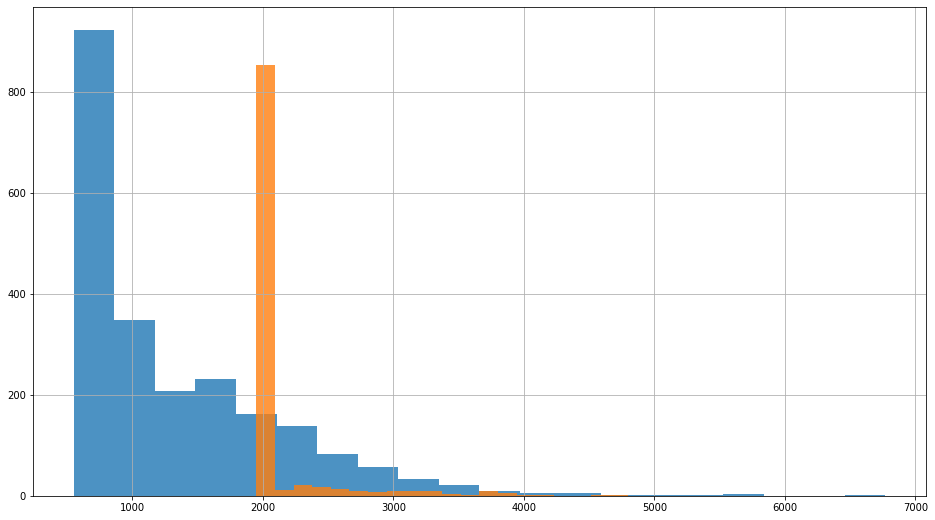

In [66]:
df.groupby('tariff_name')['payment'].hist(bins=20, figsize=(16, 9), alpha=0.8)

Гистограммы отображают распределение платежей для каждого из двух тарифов. Мы видим два больших пика, которые соответствуют абонентской плате за каждый тариф. Пользователи "ультры" в очень редких случаях платят больше абонентской платы. Таким образом они крайне редко превышают лимит минут, трафика или сообщений. Пользователей "смарта", превышающих лимит достаточно много. Однако даже с учетом этого, пользователи "смарта" в среднем платят сильно меньше. Это видно и из гистаграммы, и из расчитанного значения среднего. Пользоваться "смартом" становится не выгодно, если лимит превышается сильно, и существенные выбросы в платежах мы видим именно для "смарта", впрочем, это только выбросы.  

Посмотрим на помесячную длительность звонков в зависимости от тарифа

In [67]:
df.groupby('tariff_name')['call_duration_total'].describe()

,count,mean,std,min,25%,50%,75%,max
tariff_name,,,,,,,,
smart,2230.0,417.747534,190.476754,0.0,282.0,421.5,545.00,1435.0
ultra,986.0,526.089249,317.887549,0.0,282.5,518.0,751.75,1673.0


In [68]:
#Дисперсия значений израсходованных минут для тарифа Ультра
np.var(df[df['tariff_name'] == 'ultra']['call_duration_total'])

100950.00623331097

In [69]:
#Дисперсия значений израсходованных минут для тарифа Смарт
np.var(df[df['tariff_name'] == 'smart']['call_duration_total'])

36265.12415310985

tariff_name
smart    AxesSubplot(0.125,0.125;0.775x0.755)
ultra    AxesSubplot(0.125,0.125;0.775x0.755)
Name: call_duration_total, dtype: object

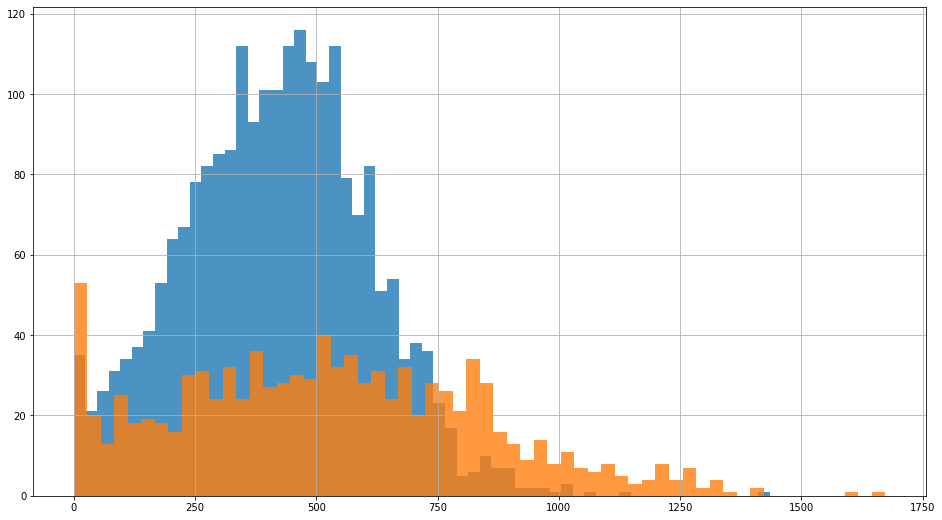

In [70]:
df.groupby('tariff_name')['call_duration_total'].hist(bins=60, figsize=(16, 9), alpha=0.8)

Здесь мы наблюдаем, что длительность звонков для тарифа "ультра" едва ли имеет форму колокола и сильно размазана по гистограмме. Выговорить лимит в 3000 минут за месяц, похоже, не удалось никому, то есть фактически у пользователей безлимит. "Размазанность" как раз свидительствет о том, что пользователи просто говорят по телефону столько, сколько им нужно. Для тарифа "смарт" гистограмма похожа на колокол с пиковым значением в районе лимита по тарифу в 500 минут и, судя по всему, скошена влево. Преодолевая значение в 500 минут гистограмма падает быстро, что говорит нам о том, что значительная часть абонентов следит за лимитом минут и не очень любит его превышать. Пользователей, выговоривших больше 800 минут для тарифа "смарт", практически нет, в то время как для "ультры" их приличное количество. Также отметим, что близких к нулю значений минут у "ультры" даже больше чем у "смарта", хотя самих пользователей "ультры" меньше примерно в 2,5 раза! Это может говорит о том, что "ультра" выбирается пользователями для большего объема интернет-трафика, а не для длительности разговора. Среднее значение потраченных минут у "ультры" ожидаемо больше, чем у "смарта", разница, однако всего около 20%, хотя лимит отличается аж в 6 раз.

Перейдем к трафику

In [71]:
df.groupby('tariff_name')['gb_used'].describe()

,count,mean,std,min,25%,50%,75%,max
tariff_name,,,,,,,,
smart,2230.0,16.321525,5.756167,0.0,13.0,17.0,20.0,38.0
ultra,986.0,19.474645,9.868057,0.0,12.0,19.0,27.0,49.0


In [72]:
#Дисперсия значений трафика для тарифа Ультра
np.var(df[df['tariff_name'] == 'ultra']['gb_used'])

97.27978308900676

In [73]:
#Дисперсия значений трафика для тарифа Ультра
np.var(df[df['tariff_name'] == 'smart']['gb_used'])

33.11859498481771

tariff_name
smart    AxesSubplot(0.125,0.125;0.775x0.755)
ultra    AxesSubplot(0.125,0.125;0.775x0.755)
Name: gb_used, dtype: object

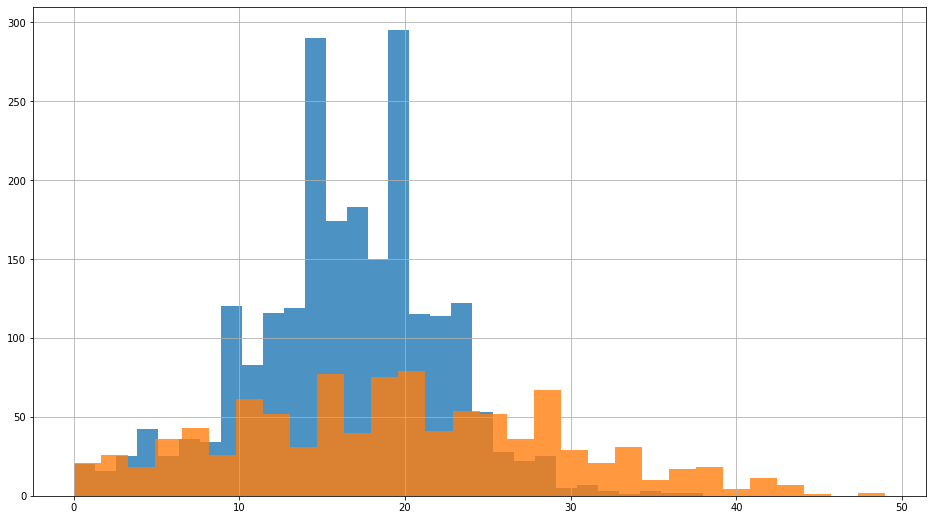

In [74]:
df.groupby('tariff_name')['gb_used'].hist(bins=30, figsize=(16, 9), alpha=0.8)

Здесь гистограмма для "ультры" уже весьма похожа на колокол, однако, как и в случае выше, он намного плавнее, чем для тарифа "смарт". В отличие от звонков, пользователей "смарта", превышающих лимит трафика намного больше. Людям сложнее уложиться в гигабайты, чем в минуты. Таким образом стратегия выбора тарифа "ультра" с целью увеличения лимита трафика не лишена смысла. Взглянув, однако, на средние значения гигабайтов, люди, похоже, не очень это понимают. Средний значения отличаются незначительно.

Посмотрим на смски.

In [75]:
df.groupby('tariff_name')['msg_count'].describe()

,count,mean,std,min,25%,50%,75%,max
tariff_name,,,,,,,,
smart,2230.0,33.369058,28.230396,0.0,10.0,28.0,51.00,143.0
ultra,986.0,49.313387,47.806040,0.0,6.0,38.0,78.75,224.0


In [76]:
#Дисперсия значений смс для тарифа Ультра
np.var(df[df['tariff_name'] == 'ultra']['msg_count'])

2283.0995570851965

In [77]:
#Дисперсия значений смс для тарифа Смарт
np.var(df[df['tariff_name'] == 'smart']['msg_count'])

796.5978766916688

tariff_name
smart    AxesSubplot(0.125,0.125;0.775x0.755)
ultra    AxesSubplot(0.125,0.125;0.775x0.755)
Name: msg_count, dtype: object

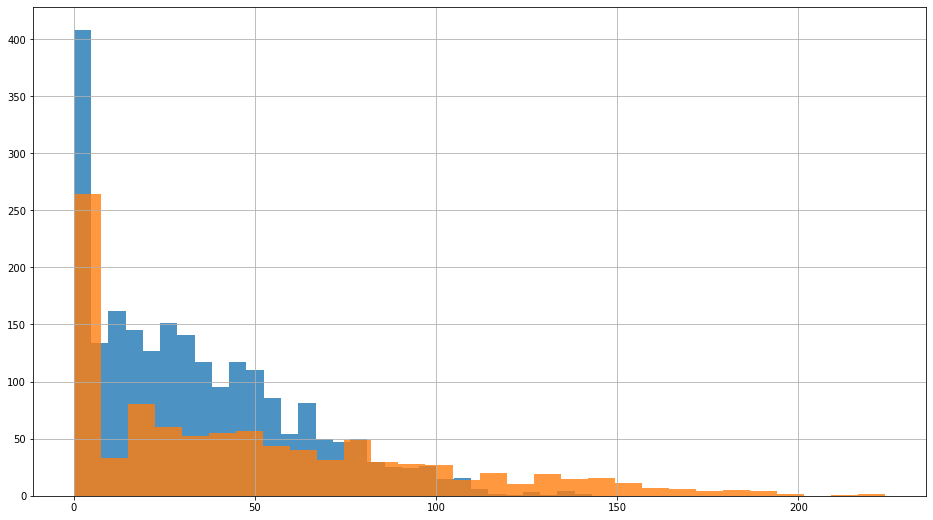

In [78]:
df.groupby('tariff_name')['msg_count'].hist(bins=30, figsize=(16, 9), alpha=0.8)

В 2018 году многие пользователи отказались от смс, это видно по двум пикам в нуле. Те, кто не отказались, лимит превышают довольно редко. У "ультры" снова более плавное распределение, и как и в случае с минутами превысить лимит практически невозможно. В отличие от трафика, однако, средние значения здесь отличаются значительно.

### Вывод

Мы проанализировали поведение пользователей двух тарифов. Распределение минут, гигабайтов и смс для "ультры" на всех графиках более плавное, чем для "смарта". Минуты и сообщения для ультры фактически безлимитны. Для "смарта", однако, большинство пользователей не превышают лимит минут и сообщений. Интернет-трафика для пользователей "смарта" недостаточно и его превышение дает компании существенную выручку. Пользователи "ультры", в свою очередь, практически никогда не платят больше абонентской платы, но размер этой платы с запасом покрывает потенциальную выручку от перерасхода минут, гб, сообщений.

## Проверка гипотез

**Гипотеза 1:** Средняя выручка пользователей тарифов "ультра" и "смарт" различаются. Это нулевая гипотеза. Альтернативная гипотеза звучит так: Средняя выручка тарифом "ультра" и "смарт" одинаковая.

In [79]:
ultra_payments = df[df['tariff_name'] == 'ultra']['payment']
smart_payments = df[df['tariff_name'] == 'smart']['payment']

In [80]:
results_tariff = st.ttest_ind(smart_payments, ultra_payments, equal_var = False)
print('p-значение: ', results_tariff.pvalue)

p-значение:  1.927011394420941e-250


Полученное p-value говорит о том, что вероятность получить такое или большее различие случайно составляет исчезающе малое число 10^-250 и оно находится очень далеко от общепринятых alpha=0.05 или alpha=0.01 Такая ничтожно малая вероятность говорит нам о том, что средняя выручка у тарифов "ультра" и "смарт" на самом деле отличаются.

**Гипотеза 2:** Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов. Альтернативная гипотеза: средняя выручка пользователей из Москвы совпадает с выручкой пользователей из других регионов.

In [81]:
moscow_payments = df[df['city'] == 'Москва']['payment']
non_moscow_payments = df[df['city'] != 'Москва']['payment']

In [82]:
results_city = st.ttest_ind(moscow_payments, non_moscow_payments, equal_var = False)
print('p-значение: ', results_city.pvalue)

p-значение:  0.5216952110000278


Полученное p-value говорит о том, что вероятность получить такое или большее различие случайно составляет 52% и находится в пределах общепринятых alpha=0.05 или alpha=0.01. Таким образом отвергаем гипотезу о различии выручки из Москвы и других городов.

## Общий вывод

Мы подробно рассмотрели два тарифа, представленных компанией "Мегалайн", проанализировали поведение пользователей и помесячную выручку с них. С уверенностью можно сказать, что каждый пользователь "ультры" в среднем приносит значительно большую выручку, чем каждый пользователь "смарта". Таким образом, стратегия компании заключается в том, чтобы как можно больше пользователей выбирали именно "ультру". Как этого добиться - решать коммерческому департаменту. Стратегия пользователя, в свою очередь, говорит о том, что "смарт" лучше "ультры", за редкими исключениями, которые случаются в основном тогда, когда пользователю требуется сильно больше интернет-трафика, чем предлагается по тарифу "смарт". В этом случае выбор "ультры" пользователем может иметь смысл.